In [1]:
import numpy as np
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from scipy.constants import mu_0
from scipy.constants import elementary_charge as q_e
from scipy.constants import proton_mass as m_i
from astropy.convolution import convolve, convolve_fft
from scipy.signal import fftconvolve

from datetime import date
from datetime import datetime
import visit_writer

import structured_3d_vtk as struc_3d
reload(struc_3d)

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

import os

import ion_current_to_mach_number as ic_to_mach
reload(ic_to_mach)

import read_from_sql

In [2]:
now = datetime.now().strftime("%Y-%m-%d-%H-%M")
out_dir = '../output/' + now
try:
    os.makedirs(out_dir)
except:
    pass

# Define functions

In [3]:
def prepare_idl_quantity(name, planes, bounds=None):
    r"""
    """
    measurements = struc_3d.read_idl(name, )
    if bounds:
        measurements = struc_3d.remove_points_out_of_bounds(measurements, 
                                                            bounds[0], bounds[1], planes)
    for plane in planes:
        measurements[plane] = struc_3d.average_duplicate_points(measurements[plane])
    return measurements

In [4]:
def combine_all_planes(measurements, planes):
    r"""
    """
    all_planes = dict(measurements[planes[0]])
    all_planes['z_out'] = planes[0]*np.ones(all_planes['x_out'].size) 
    for plane in planes[1:]:
        for key in ['x_out', 'y_out']:
            all_planes[key] = np.concatenate((all_planes[key], 
                                              measurements[plane][key]))
        all_planes['z_out'] = np.concatenate((all_planes['z_out'],
                                              plane*np.ones(measurements[plane]['x_out'].size)))
        for key in ['std', 'a_out']:
            for time_point in xrange(measurements[plane]['delays'].size):
                all_planes[key][time_point] = np.concatenate((all_planes[key][time_point], 
                                                              measurements[plane][key][time_point]))
    return all_planes

In [5]:
def remove_points_outside_convex(measurements,
                                 x_min= -0.025, x_max=0.025,
                                 y_min=-0.016, y_max=0.017,
                                 z_min=0.249, z_max=0.416):
    r"""
    """
    points = np.dstack((measurements['x_out'], 
                        measurements['y_out'], 
                        measurements['z_out']))[0]
    outside_convex_volume = np.where(np.logical_or.reduce((points[:, 0] < x_min, 
                                                           points[:, 0] > x_max, 
                                                           points[:, 1] < y_min,
                                                           points[:, 1] > y_max,
                                                           points[:, 2] < z_min,
                                                           points[:, 2] > z_max)))[0]
    for key in ['x_out', 'y_out', 'z_out']:
        measurements[key] = np.delete(measurements[key], 
                                      outside_convex_volume)
    for key in ['std', 'a_out']:
        for time_point in xrange(measurements['delays'].size):
            measurements[key][time_point] = np.delete(measurements[key][time_point], 
                                                      outside_convex_volume)
    return measurements

In [6]:
def remove_points_outside_convex(measurements,
                                 x_min= -0.025, x_max=0.025,
                                 y_min=-0.016, y_max=0.017,
                                 z_min=0.249, z_max=0.416):
    r"""
    """
    points = np.dstack((measurements['x_out'], 
                        measurements['y_out'], 
                        measurements['z_out']))[0]
    outside_convex_volume = np.where(np.logical_or.reduce((points[:, 0] < x_min, 
                                                           points[:, 0] > x_max, 
                                                           points[:, 1] < y_min,
                                                           points[:, 1] > y_max,
                                                           points[:, 2] < z_min,
                                                           points[:, 2] > z_max)))[0]
    for key in ['x_out', 'y_out', 'z_out']:
        measurements[key] = np.delete(measurements[key], 
                                      outside_convex_volume)
    for key in ['std', 'a_out']:
        for time_point in xrange(measurements['delays'].size):
            measurements[key][time_point] = np.delete(measurements[key][time_point], 
                                                      outside_convex_volume)
    return measurements

In [7]:
def remove_nan_points(measurements):
    r"""
    """
    nan_positions = np.where(np.isnan(measurements['a_out']))[1]
    for key in ['x_out', 'y_out', 'z_out']:
        measurements[key] = np.delete(measurements[key], 
                                      nan_positions)
    for key in ['std', 'a_out']:
        measurements[key] = np.delete(measurements[key], 
                                      nan_positions, axis=1)
    return measurements

In [8]:
def prepare_for_unstructured_vtk(measurements, quantity_name):
    r"""
    """
    points = np.dstack((measurements['x_out'], 
                        measurements['y_out'], 
                        measurements['z_out']))[0]
    triangulation = Delaunay(points)
    points = tuple(points.ravel())
    connectivity = tuple([(visit_writer.tetrahedron, int(simplex[0]), 
                           int(simplex[1]), int(simplex[2]), int(simplex[3])) 
                           for simplex in triangulation.simplices])
    variables_all_time = []
    for time_point in xrange(measurements['delays'].size):
        variables = ((quantity_name, 1, 1, tuple(measurements['a_out'][time_point])),)
        variables_all_time.append(variables)
    return points, connectivity, variables_all_time

In [9]:
def give_delaunay_and_interpolator(measurements):
    r"""
    """
    if np.unique(measurements['z_out']).size < 2:
        points = np.dstack((measurements['x_out'], 
                            measurements['y_out']))[0]
    else:
        points = np.dstack((measurements['x_out'], 
                            measurements['y_out'], 
                            measurements['z_out']))[0]
    triangulation = Delaunay(points)
    interpolators = []
    for time_point in xrange(measurements['delays'].size):
        interpolators.append(LinearNDInterpolator(points, measurements['a_out'][time_point]))
    return triangulation, interpolators

In [10]:
def write_all_time_unstructured(file_prefix, points, connectivity, variables_all_time):
    r"""
    """
    for time_point in xrange(len(variables_all_time)):
        path = file_prefix + str(time_point).zfill(4)
        visit_writer.WriteUnstructuredMesh(path, 1, points,
                                           connectivity, 
                                           variables[time_point])

In [11]:
def save_idl_quantity_to_unstructured_grids(idl_quantity_name,
                                            visit_quantity_name,
                                            date, 
                                            planes=[0.249, 0.302, 0.357, 0.416],
                                            file_name_descriptor='_all_planes_convex_unstructured_grid_',
                                            x_min= -0.021, x_max=0.014,
                                            y_min=-0.016, y_max=0.017,
                                            z_min=0.249, z_max=0.416,
                                            bounds=None):
    r"""
    """
    file_prefix = '../output/' + date + '/' + visit_quantity_name + file_name_descriptor
    measurements = prepare_idl_quantity(idl_quantity_name, planes, bounds=bounds)
    all_planes = combine_all_planes(measurements, planes) 
    all_planes = remove_points_outside_convex(all_planes, 
                                              x_min=x_min, x_max=x_max,
                                              y_min=y_min, y_max=y_max,
                                              z_min=z_min, z_max=z_max)
    assert len(all_planes['x_out']) == len(all_planes['y_out']) == len(all_planes['z_out'])
    #(points, 
    # connectivity, 
    # variables_all_time) = prepare_for_unstructured_vtk(all_planes, visit_quantity_name)
    #assert len(points) == len(all_planes['x_out'])*3
    #assert len(variables_all_time[0][0][3]) == len(all_planes['x_out'])
    #write_all_time_unstructured(file_prefix, points, 
    #                            connectivity, variables_all_time)
    return all_planes 

In [12]:
def save_quantity_to_unstructured_grids(measurements,
                                        idl_quantity_name,
                                        visit_quantity_name,
                                        date, 
                                        planes=[0.249, 0.302, 0.357, 0.416],
                                        file_name_descriptor='_all_planes_convex_unstructured_grid_',
                                        x_min= -0.021, x_max=0.014,
                                        y_min=-0.016, y_max=0.017,
                                        z_min=0.249, z_max=0.416,
                                        bounds=None):
    r"""
    """
    file_prefix = '../output/' + date + '/' + visit_quantity_name + file_name_descriptor
    all_planes = combine_all_planes(measurements, planes) 
    all_planes = remove_points_outside_convex(all_planes, 
                                              x_min=x_min, x_max=x_max,
                                              y_min=y_min, y_max=y_max,
                                              z_min=z_min, z_max=z_max)
    assert len(all_planes['x_out']) == len(all_planes['y_out']) == len(all_planes['z_out'])
    #(points, 
    # connectivity, 
    # variables_all_time) = prepare_for_unstructured_vtk(all_planes, visit_quantity_name)
    #assert len(points) == len(all_planes['x_out'])*3
    #assert len(variables_all_time[0][0][3]) == len(all_planes['x_out'])
    #write_all_time_unstructured(file_prefix, points, 
    #                            connectivity, variables_all_time)
    return all_planes 

In [13]:
def triangulate_derivatives(mesh, triangulation, interpolator, increment=0.00001):
    r"""
    """
    d_dx_mesh = np.zeros(mesh[0].shape)
    d_dy_mesh = np.zeros(mesh[0].shape)
    d_dz_mesh = np.zeros(mesh[0].shape)
    points = np.dstack((mesh[0].ravel(),
                        mesh[1].ravel(),
                        mesh[2].ravel()))
    values = interpolator(points)
    d_dx = (interpolator(points + np.asarray([increment, 0, 0])) - values) / increment
    d_dy = (interpolator(points + np.asarray([0, increment, 0])) - values) / increment
    d_dz = (interpolator(points + np.asarray([0, 0, increment])) - values) / increment
    d_dx_mesh = d_dx.reshape(mesh[0].shape)
    d_dy_mesh = d_dy.reshape(mesh[0].shape)
    d_dz_mesh = d_dz.reshape(mesh[0].shape)
    derivative_meshes = ([d_dx_mesh, d_dy_mesh, d_dz_mesh])
    return derivative_meshes

In [14]:
def remove_edges_derivative_meshes(derivative_meshes,
                                   x_start=2, x_end=None, 
                                   y_start=0, y_end=-2, 
                                   z_start=0, z_end=-1):
    r"""
    """
    for index in xrange(len(derivative_meshes)):
        derivative_meshes[index] = derivative_meshes[index][y_start:y_end, x_start:x_end, z_start:z_end]
    return derivative_meshes

In [15]:
def remove_edges_vector_quantity_meshes(quantity_meshes,
                                        x_start=2, x_end=None, 
                                        y_start=0, y_end=-2, 
                                        z_start=0, z_end=-1):
    r"""
    """
    for index in xrange(len(quantity_meshes)):
        quantity_meshes[index] = quantity_meshes[index][y_start:y_end, x_start:x_end, z_start:z_end]
    return quantity_meshes

In [16]:
def remove_edges_scalar_quantity_meshes(quantity_mesh,
                                        x_start=2, x_end=None, 
                                        y_start=0, y_end=-2, 
                                        z_start=0, z_end=-1):
    r"""
    """
    quantity_mesh = quantity_mesh[y_start:y_end, x_start:x_end, z_start:z_end]
    return quantity_mesh

In [17]:
def remove_edges_mesh(mesh,
                      x_start=2, x_end=None, 
                      y_start=0, y_end=-2, 
                      z_start=0, z_end=-1):
    r"""
    """
    for index in xrange(len(mesh)):
        mesh[index] = mesh[index][y_start:y_end, x_start:x_end, z_start:z_end]
    return mesh

In [18]:
def prepare_for_rectilinear_grid(mesh, quantities, quantity_names):
    r"""
    """
    x = tuple(np.unique(mesh[0]))
    y = tuple(np.unique(mesh[1]))
    z = tuple(np.unique(mesh[2]))
    variables = [(quantity_names[index], 1, 1, 
                  tuple(np.swapaxes(np.swapaxes(quantities[index], 1, 2), 0, 1).ravel()))
                 for index in xrange(len(quantities))]
    return x, y, z, variables

In [ ]:
def save_to_numpy_mesh(mesh, quantities, quantity_names, filename):
    r"""
    """
    dict_to_save = {'mesh_x': mesh[0],
                    'mesh_y': mesh[1],
                    'mesh_z': mesh[2]}
    for i, quanitity in enumerate(quantities):
        dict_to_save[quantity_names[i]] = quantities
    np.savez(filename, **dict_to_save)

In [19]:
def current_on_mesh(derivative_meshes_all_directions, mu_0=mu_0):
    r"""
    """
    dBx_dy = derivative_meshes_all_directions[0][1]
    dBx_dz = derivative_meshes_all_directions[0][2]
    dBy_dx = derivative_meshes_all_directions[1][0]
    dBy_dz = derivative_meshes_all_directions[1][2]
    dBz_dx = derivative_meshes_all_directions[2][0]
    dBz_dy = derivative_meshes_all_directions[2][1]
    j_x = 1./(mu_0) * (dBz_dy - dBy_dz)
    j_y = 1./(mu_0) * (dBx_dz - dBz_dx)
    j_z = 1./(mu_0) * (dBy_dx - dBx_dy)
    current = [j_x, j_y, j_z]    
    return current

In [20]:
def b_field_on_mesh(interpolator_all_directions, mesh, bias=2e-2):
    r"""
    """
    shape = mesh[0].shape
    points = np.swapaxes(np.asarray([mesh[0].ravel(), mesh[1].ravel(), mesh[2].ravel()]), 0, 1)
    b_x = interpolator_all_directions[0](points)  
    b_y = interpolator_all_directions[1](points)
    b_z = interpolator_all_directions[2](points)
    b_x = np.resize(b_x, shape)
    b_y = np.resize(b_y, shape)
    b_z = np.resize(b_z, shape)
    b_z += bias 
    b_x_norm = b_x / np.sqrt(b_x**2. + b_y**2. + b_z**2.)
    b_y_norm = b_y / np.sqrt(b_x**2. + b_y**2. + b_z**2.)
    b_z_norm = b_z / np.sqrt(b_x**2. + b_y**2. + b_z**2.)    
    b_field = [b_x, b_y, b_z]
    b_field_norm = [b_x_norm, b_y_norm, b_z_norm]
    return b_field, b_field_norm

In [21]:
def scalar_on_mesh(interpolator, mesh):
    r"""
    """
    shape = mesh[0].shape
    assert (len(mesh) == 3 or len(mesh) == 2)
    if len(mesh) == 3:
        points = np.swapaxes(np.asarray([mesh[0].ravel(), mesh[1].ravel(), mesh[2].ravel()]), 0, 1)
    else:
        points = np.swapaxes(np.asarray([mesh[0].ravel(), mesh[1].ravel()]), 0, 1)
    scalar_all_times = []
    scalar = interpolator(points)
    scalar = np.resize(scalar, shape)
    return scalar

In [22]:
def write_fields_and_currents_to_structured_mesh(date, visit_file_name, 
                                                 x, y, z, data, time_point):
    r"""
    """
    file_prefix = '../output/' + date + '/' + visit_file_name
    path = file_prefix + str(time_point).zfill(4)  
    print path
    visit_writer.WriteRectilinearMesh(path, 1, x, y, z, data)

In [23]:
def bdot_probe_extent():
    r"""
    """
    x_min = -0.026
    x_max = 0.024
    y_min = -0.02 
    y_max = 0.028
    z_min = 0.249 
    z_max = 0.416
    return x_min, x_max, y_min, y_max, z_min, z_max

def joint_bdot_tp_extent():
    r"""
    """
    x_min = -0.022
    x_max = 0.024
    y_min = -0.02 
    y_max = 0.024
    z_min = 0.249 
    z_max = 0.416
    return x_min, x_max, y_min, y_max, z_min, z_max

def joint_mach_bdot_tp_extent():
    r"""
    """
    x_min = -0.022
    x_max = 0.024
    y_min = -0.02 
    y_max = 0.018
    z_min = 0.249 
    z_max = 0.416
    return x_min, x_max, y_min, y_max, z_min, z_max

In [24]:
def calc_ion_velocity_term_1(current, density, charge):
    r"""
    """
    denominator = density*charge
    term = [current[0]/denominator,
            current[1]/denominator,
            current[2]/denominator]
    return term

In [25]:
def calc_ion_velocity_term_2(b_field_norm, alpha):
    r"""
    """
    return alpha*b_field_norm

In [26]:
def curl_on_mesh(quantity, mesh):
    r"""
    """
    dx = mesh[0][0, 1, 0] - mesh[0][0, 0, 0]
    dy = mesh[1][1, 0, 0] - mesh[1][0, 0, 0]
    dz = mesh[2][0, 0, 1] - mesh[2][0, 0, 0]
    dx_dy = np.gradient(quantity[0], axis=1)/dy
    dx_dz = np.gradient(quantity[0], axis=2)/dz
    dy_dx = np.gradient(quantity[1], axis=0)/dx
    dy_dz = np.gradient(quantity[1], axis=2)/dz
    dz_dx = np.gradient(quantity[2], axis=0)/dx
    dz_dy = np.gradient(quantity[2], axis=1)/dy
    curl_x = dz_dy - dy_dz
    curl_y = dx_dz - dz_dx
    curl_z = dy_dx - dx_dy
    return [curl_x, curl_y, curl_z]

In [27]:
def calc_ion_vorticity_term_1(current, density, charge, mesh, filt=None):
    r"""
    """
    return curl_on_mesh(calc_ion_velocity_term_1(current, density, charge), mesh)

In [28]:
def calc_ion_vorticity_term_2(b_field_norm, alpha, mesh):
    r"""
    """
    return curl_on_mesh(calc_ion_velocity_term_2(b_field_norm, alpha), mesh)

In [29]:
def boxcar_filter_quantity_mesh(quantity, width):
    r"""
    """
    nan_indexes = np.where(np.isnan(quantity))
    quantity[nan_indexes] = 0
    boxcar = np.ones((width, width, width))
    boxcar /= boxcar.sum()
    return fftconvolve(quantity, boxcar, mode='same')

# Write all idl quantities to files

In [30]:
bx_all_planes = save_idl_quantity_to_unstructured_grids('bx', 'B_x', now,
                                                        x_min=-0.032, x_max=0.028,
                                                        y_min=-0.022, y_max=0.032, 
                                                        z_min=0.249, z_max=0.416)



In [31]:
by_all_planes = save_idl_quantity_to_unstructured_grids('by', 'B_y', now,
                                                        x_min=-0.032, x_max=0.028,
                                                        y_min=-0.022, y_max=0.032, 
                                                        z_min=0.249, z_max=0.416)


In [32]:
bz_all_planes = save_idl_quantity_to_unstructured_grids('bz', 'B_z', now,
                                                        x_min=-0.032, x_max=0.028,
                                                        y_min=-0.022, y_max=0.032, 
                                                        z_min=0.249, z_max=0.416)


In [33]:
te_all_planes = save_idl_quantity_to_unstructured_grids('te', 'T_e', now, 
                                                        x_min=-0.026, x_max=0.028,
                                                        y_min=-0.03, y_max=0.028, 
                                                        z_min=0.249, z_max=0.416,
                                                        bounds=(1e-3, 1e3))


In [34]:
n_all_planes = save_idl_quantity_to_unstructured_grids('n', 'n', now,
                                                       x_min=-0.026, x_max=0.028,
                                                       y_min=-0.03, y_max=0.028, 
                                                       z_min=0.249, z_max=0.416,
                                                       bounds=(1e3, 1e22))


# Prepare Mach probe data 

In [35]:
timesteps = 250

database = '/Users/vonderlinden2/rsx_analysis/shots_database/source/shots.db'
table = 'Shots'
z_direction_1, z_direction_2 = 0, 180
y_direction_1, y_direction_2 = 90, 270
angle_signs = {0: 1,
               180: -1,
               90: -1,
               0: 1}
min_spectral_density = 1.6e-8

condition_z_0416 = ("campaigns = 'mach_probe_plane_campaign_1'"
                    " AND fiducial_pre_crowbar_gyration_spectral_density > "
                    + str(min_spectral_density) +
                    " AND mach_signals_exist = 1"
                    " AND (mach_orientation = " + str(z_direction_1) +
                    " OR mach_orientation = " + str(z_direction_2) + ")")

condition_y_0416 = ("campaigns = 'mach_probe_plane_campaign_1'"
                    " AND fiducial_pre_crowbar_gyration_spectral_density > "
                    + str(min_spectral_density) +
                    " AND mach_signals_exist = 1"
                    " AND (mach_orientation = " + str(y_direction_1) +
                    " OR mach_orientation = " + str(y_direction_2) + ")")

cursor, connection = read_from_sql.cursor_with_rows(condition_z_0416,
                                                    database,
                                                    table)
z_0416_shots = cursor.fetchall()
cursor.close()
connection.close()

cursor, connection = read_from_sql.cursor_with_rows(condition_y_0416,
                                                    database,
                                                    table)
y_0416_shots = cursor.fetchall()
cursor.close()
connection.close()

condition_z_302 = ("campaigns = 'mach_probe_plane_campaign_2'"
                   " AND fiducial_pre_crowbar_gyration_spectral_density > "
                   + str(min_spectral_density) +
                   " AND mach_signals_exist = 1"
                   " AND (mach_orientation = " + str(z_direction_1) +
                   " OR mach_orientation = " + str(z_direction_2) + ")")

cursor, connection = read_from_sql.cursor_with_rows(condition_z_302,
                                                    database,
                                                    table)
z_0302_shots = cursor.fetchall()
cursor.close()
connection.close()

mach_z_0416_measurements = ic_to_mach.run_mach_analysis(z_0416_shots,
                                                        timesteps, 
                                                        angle_signs) 
mach_y_0416_measurements = ic_to_mach.run_mach_analysis(y_0416_shots,
                                                        timesteps, 
                                                        angle_signs)
mach_z_0302_measurements = ic_to_mach.run_mach_analysis(z_0302_shots,
                                                        timesteps, 
                                                        angle_signs)

mach_z_0416_measurements['delays'] = np.arange(timesteps)
mach_y_0416_measurements['delays'] = np.arange(timesteps)
mach_z_0302_measurements['delays'] = np.arange(timesteps)

mach_z_0416_measurements = struc_3d.average_duplicate_points(mach_z_0416_measurements)
mach_y_0416_measurements = struc_3d.average_duplicate_points(mach_y_0416_measurements)
mach_z_0302_measurements = struc_3d.average_duplicate_points(mach_z_0302_measurements)

mach_y_measurements = {0.416: mach_y_0416_measurements}
mach_z_measurements = {0.302: mach_z_0302_measurements,
                       0.416: mach_z_0416_measurements}

mach_y_all_planes = save_quantity_to_unstructured_grids(mach_y_measurements, 
                                                        'Mach_y', 'Mach_y', '2016-07-26',
                                                        planes=[0.416],
                                                        x_min=-0.052, x_max=0.052,
                                                        y_min=-0.022, y_max=0.032, 
                                                        z_min=0.249, z_max=0.416,
                                                        bounds=(-10, 10))

mach_z_all_planes = save_quantity_to_unstructured_grids(mach_z_measurements, 
                                                        'Mach_z', 'Mach_z', '2016-07-26',
                                                        planes=[0.302, 0.416],
                                                        x_min=-0.032, x_max=0.032,
                                                        y_min=-0.022, y_max=0.032, 
                                                        z_min=0.249, z_max=0.416,
                                                        bounds=(-10, 10))
mach_y_all_planes = remove_nan_points(mach_y_all_planes)
mach_z_all_planes = remove_nan_points(mach_z_all_planes)

# Determine derivatives and write to files

In [36]:
bx_triangulation, bx_interpolators = give_delaunay_and_interpolator(bx_all_planes)
by_triangulation, by_interpolators = give_delaunay_and_interpolator(by_all_planes)
bz_triangulation, bz_interpolators = give_delaunay_and_interpolator(bz_all_planes)
te_triangulation, te_interpolators = give_delaunay_and_interpolator(te_all_planes)
n_triangulation, n_interpolators = give_delaunay_and_interpolator(n_all_planes)
mach_y_triangulation, mach_y_interpolators = give_delaunay_and_interpolator(mach_y_all_planes)
mach_z_triangulation, mach_z_interpolators = give_delaunay_and_interpolator(mach_z_all_planes)

# Interpolate mach and temperature in plane calculate ion velocity

In [37]:
(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mach_y_interpolator = mach_y_interpolators[70]
mach_z_interpolator = mach_z_interpolators[70]
te_interpolator = te_interpolators[0]
 
mach_y = scalar_on_mesh(mach_y_interpolator, mesh[:2])
mach_z = scalar_on_mesh(mach_z_interpolator, mesh)
te = scalar_on_mesh(te_interpolator, mesh)

u_i_y = np.sqrt(te*q_e/m_i)*mach_y
u_i_z = np.sqrt(te*q_e/m_i)*mach_z

u_i_y = np.reshape(u_i_y, mesh[0].shape)
u_i_z = np.reshape(u_i_z, mesh[0].shape)

u_i_y = u_i_y[3:, :]
u_i_z = u_i_z[3:, :]

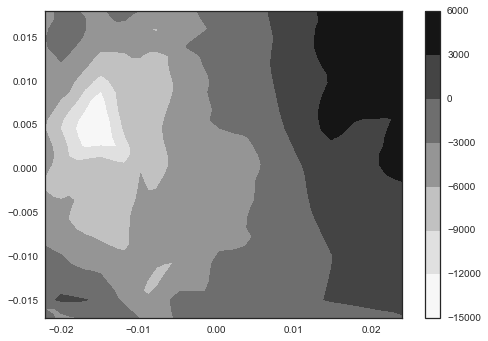

In [40]:
plt.contourf(mesh[0][3:,:,0], mesh[1][3:,:,0], u_i_y[:,:,0])
plt.colorbar()

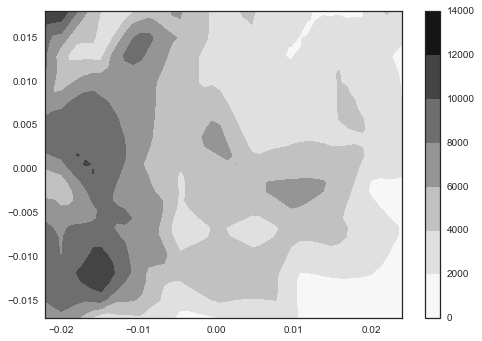

In [41]:
plt.contourf(mesh[0][3:,:,0], mesh[1][3:,:,0], u_i_z[:,:,-1])
plt.colorbar()

In [42]:
filter_width = 15
ones = np.ones(mesh[0].shape)
alpha=8.1e5
time_point = 0
print time_point
bx_interpolator = bx_interpolators[time_point]
by_interpolator = by_interpolators[time_point]
bz_interpolator = bz_interpolators[time_point]
te_interpolator = te_interpolators[time_point]
n_interpolator = n_interpolators[time_point]
    
bx_derivative = triangulate_derivatives(mesh, bx_triangulation, bx_interpolator, 
                                            increment=0.0000001)
by_derivative = triangulate_derivatives(mesh, by_triangulation, by_interpolator, 
                                               increment=0.0000001)
bz_derivative = triangulate_derivatives(mesh, bz_triangulation, bz_interpolator, 
                                               increment=0.0000001)


current = current_on_mesh([bx_derivative, 
                               by_derivative, 
                               bz_derivative])
b_field, b_field_norm = b_field_on_mesh([bx_interpolator, 
                                             by_interpolator,
                                             bz_interpolator], mesh, bias=2e-2)

temperature = scalar_on_mesh(te_interpolator, mesh)
density = scalar_on_mesh(n_interpolator, mesh)

current = np.asarray(current)
density = np.asarray(density)
b_field_norm = np.asarray(b_field_norm)

density = boxcar_filter_quantity_mesh(density, filter_width)

for direction in xrange(len(current)):
    current[direction] = boxcar_filter_quantity_mesh(current[direction], filter_width)
density = 1e18*np.ones(density.shape)
    
ion_velocity_term_1 = calc_ion_velocity_term_1(current, density, q_e)
ion_velocity_term_2 = calc_ion_velocity_term_2(b_field_norm, alpha)

ion_vorticity_term_1 = calc_ion_vorticity_term_1(current, density, q_e, mesh)
ion_vorticity_term_2 = calc_ion_vorticity_term_2(b_field_norm, alpha, mesh)

for direction in xrange(len(ion_vorticity_term_1)):
    ion_vorticity_term_1[direction] = boxcar_filter_quantity_mesh(ion_vorticity_term_1[direction], filter_width)
    ion_vorticity_term_2[direction] = boxcar_filter_quantity_mesh(ion_vorticity_term_2[direction], filter_width)

0


# Joint quantities interpolation

In [116]:
filter_width = 15

In [45]:
now = datetime.now().strftime("%Y-%m-%d-%H-%M")
out_dir = '../output/' + now
try:
    os.makedirs(out_dir)
except:
    pass

alpha = 1

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = joint_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mesh_wo_edges = remove_edges_mesh([np.array(mesh[0]), 
                                   np.array(mesh[1]), 
                                   np.array(mesh[2])])
ones = np.ones(mesh_wo_edges[0].shape)

quantity_names = ['B_x', 'B_y', 'B_z',
                  'B_norm_x', 'B_norm_y', 'B_norm_z',
                  'j_x', 'j_y', 'j_z', 'n', 'Te',
                  'u_i_term1_x', 'u_i_term1_y', 'u_i_term1_z',
                  'u_e_norm_x', 'u_e_norm_y', 'u_e_norm_z',
                  'w_i_term1_x', 'w_i_term1_y', 'w_i_term1_z',
                  'w_i_term2_x', 'w_i_term2_y', 'w_i_term2_z',
                  'u_i_term1_x_constant_density', 'u_i_term1_y_constant_density', 'u_i_term1_z_constant_density',
                  'w_i_term1_x_constant_density', 'w_i_term1_y_constant_density', 'w_i_term1_z_constant_density',
                  'ones']

for time_point in xrange(len(bx_interpolators)):
    print time_point
    bx_interpolator = bx_interpolators[time_point]
    by_interpolator = by_interpolators[time_point]
    bz_interpolator = bz_interpolators[time_point]
    te_interpolator = te_interpolators[time_point]
    n_interpolator = n_interpolators[time_point]
    
    bx_derivative = triangulate_derivatives(mesh, bx_triangulation, bx_interpolator, 
                                            increment=0.0000001)
    bx_derivative = remove_edges_derivative_meshes(bx_derivative)
    by_derivative = triangulate_derivatives(mesh, by_triangulation, by_interpolator, 
                                               increment=0.0000001)
    by_derivative = remove_edges_derivative_meshes(by_derivative)
    bz_derivative = triangulate_derivatives(mesh, bz_triangulation, bz_interpolator, 
                                               increment=0.0000001)
    bz_derivative = remove_edges_derivative_meshes(bz_derivative)


    current = current_on_mesh([bx_derivative, 
                               by_derivative, 
                               bz_derivative])
    b_field, b_field_norm = b_field_on_mesh([bx_interpolator, 
                                             by_interpolator,
                                             bz_interpolator], mesh_wo_edges, bias=2e-2)

    temperature = scalar_on_mesh(te_interpolator, mesh_wo_edges)
    density = scalar_on_mesh(n_interpolator, mesh_wo_edges)

    current = np.asarray(current)
    density = np.asarray(density)
    b_field_norm = np.asarray(b_field_norm)

    density = boxcar_filter_quantity_mesh(density, filter_width)

    for direction in xrange(len(current)):
        current[direction] = boxcar_filter_quantity_mesh(current[direction], filter_width)

    density_constant = 1e18*np.ones(density.shape)
        
    ion_velocity_term_1 = calc_ion_velocity_term_1(current, density, q_e)
    ion_velocity_term_1_constant_density = calc_ion_velocity_term_1(current, density_constant, q_e)
    ion_velocity_term_2 = calc_ion_velocity_term_2(b_field_norm, alpha)

    ion_vorticity_term_1 = calc_ion_vorticity_term_1(current, density, q_e, mesh_wo_edges)
    ion_vorticity_term_1_constant_density = calc_ion_vorticity_term_1(current, density_constant, q_e, mesh_wo_edges)
    ion_vorticity_term_2 = calc_ion_vorticity_term_2(b_field_norm, alpha)

    for direction in xrange(len(ion_vorticity_term_1)):
        ion_vorticity_term_1[direction] = boxcar_filter_quantity_mesh(ion_vorticity_term_1[direction], filter_width)
        ion_vorticity_term_1_constant_density[direction] = boxcar_filter_quantity_mesh(ion_vorticity_term_1_constant_density[direction], filter_width)
        ion_vorticity_term_2[direction] = boxcar_filter_quantity_mesh(ion_vorticity_term_2[direction], filter_width)

    
        
    fields = (list(b_field) + list(b_field_norm) + list(current) + 
              [density] + [temperature] +
              list(ion_velocity_term_1) + list(ion_velocity_term_2) +
              list(ion_vorticity_term_1) + list(ion_vorticity_term_2) +
              list(ion_velocity_term_1_constant_density) +
              list(ion_vorticity_term_1_constant_density)
              [ones])

    numpy_archive_name = out_dir + 'Bdot_triple_probe_quantities' + str(time_point).zfill(4) + '.npz'
    save_to_numpy_mesh(mesh_wo_edges, fields, quantity_names, filename)    
    
    x, y, z, variables = prepare_for_rectilinear_grid(mesh_wo_edges, fields,
                                                      quantity_names)

    write_fields_and_currents_to_structured_mesh(now, 'Bdot_triple_probe_quantities', x, y, z, variables, time_point)

0


TypeError: calc_ion_vorticity_term_2() takes exactly 3 arguments (2 given)

In [69]:
print 'density between', density.max(), density.min(), density.mean()
print 'abs density between', np.abs(density).max(), np.abs(density).min(), np.abs(density).mean()
print 'charge', q_e
print 'current x between', current[0].max(), current[0].min(), current[0].mean()
print 'current y between', current[1].max(), current[1].min(), current[1].mean()
print 'current z between', current[2].max(), current[2].min(), current[2].mean()
denominator = density*q_e
print 'denominator between', denominator.max(), denominator.min(), denominator.mean()
print 'abs denominator between', np.abs(denominator).max(), np.abs(denominator).min(), np.abs(denominator).mean()
term = [current[0]/denominator,
        current[1]/denominator,
        current[2]/denominator]
print 'term x between', term[0].max(), term[0].min(), term[0].mean()
print 'term y between', term[1].max(), term[1].min(), term[1].mean()
print 'term z between', term[2].max(), term[2].min(), term[2].mean()

density between 7.18761714797e+19 1.26165033215e+17 7.67230104918e+18
abs density between 7.18761714797e+19 1.26165033215e+17 7.67230104918e+18
charge 1.6021766208e-19
current x between 1445823.091 -664716.029921 287.957349552
current y between 1715203.22622 -1893650.19427 -3720.90718255
current z between 3060044.45744 -2740383.91419 -28779.1816356
denominator between 11.5158321537 0.020213866658 1.22923813687
abs denominator between 11.5158321537 0.020213866658 1.22923813687
term x between 13140771.3648 -4042828.16287 1798.77853144
term y between 8944163.4699 -8274999.82743 -4840.150886
term z between 7991128.24954 -7980696.62142 -10766.3934199
